In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats as stats
import seaborn as sns

import data with address line and process it

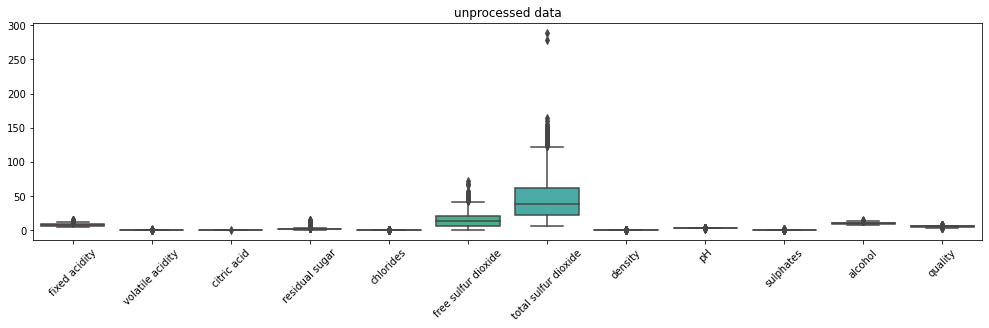

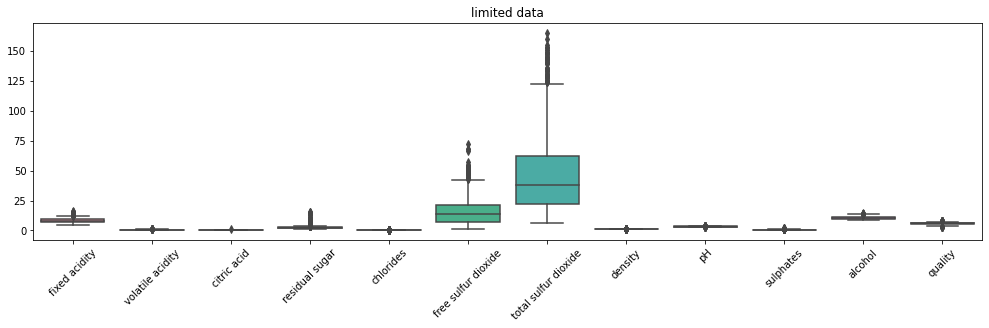

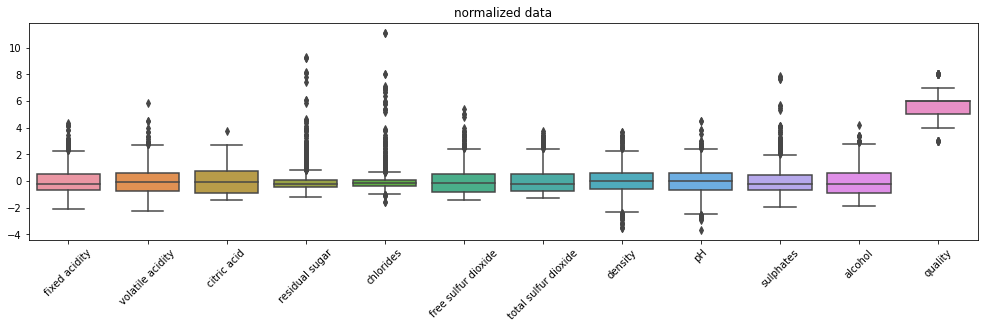

<ipython-input-5-87760e06ddda>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [5]:
#data import
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
#data showing
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('unprocessed data')

#set data limit
data=data[data['total sulfur dioxide']<200]
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('limited data')
#apply z-score normalization to all columns expect for quality
cols2zscore=data.keys()
cols2zscore=cols2zscore.drop('quality')
data[cols2zscore]=data[cols2zscore].apply(stats.zscore)
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('normalized data')
plt.show()

data['boolQuality']=0
data['boolQuality'][data['quality']>5] = 1

data split to part:train and test

In [ ]:
dataT=torch.tensor(data[cols2zscore].values).float()
labels=torch.tensor(data['boolQuality'].values).float()
labels=labels[:,None]

# data and labels spilt with sklearn
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=.1)

#convert to pytorch dataset
train_Dataset=TensorDataset(train_data,train_labels)                                                          
test_Dataset=TensorDataset(test_data,test_labels)

train_loader=DataLoader(train_Dataset,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_Dataset,batch_size=test_Dataset.tensors[0].shape[0])

let create ANN model with batch normalization

In [ ]:
class ANN_wine_withBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        #input layer
        self.input=nn.Linear(11,16)

        #hidden layers
        self.fc1=nn.Linear(16,32)
        self.bNorm1=nn.BatchNorm1d(16)
        self.fc2=nn.Linear(32,20)
        self.bNorm2=nn.BatchNorm1d(32)

        #output layer
        self.output=nn.Linear(20,1)

    def forward(self,x,doing_BT):
        x=F.relu(self.input(x))

        if doing_BT:
            # hidden layer1
            x=self.bNorm1(x)#batchnorm
            x=F.relu(self.fc1(x)) 

            # hidden layer2
            x=self.bNorm2(x)
            x=F.relu(self.fc2(x))

        else:
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))

        return self.output(x)

In [ ]:
def createTheModel():
    ANN_wine=ANN_wine_withBatchNorm()
    lossfun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(ANN_wine.parameters(),lr=.01)
    
    return ANN_wine,lossfun,optimizer

In [ ]:
def trainTheModel(train=None,test=None,ANN_wine=None,lossfun=None,optimizer=None,\
                    Numepoch=500,do_BN=False):
    trainAcc=[]
    testAcc=[]
    losses=torch.zeros(Numepoch)

    for epoch in range(Numepoch):
        batchacc=[]
        batchloss=[]

        ANN_wine.train()

        for dat,lab in train:

            yHat=ANN_wine(dat,do_BN)
            loss=lossfun(yHat,lab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchloss.append(loss.item())
            batchacc.append(100*torch.mean(((yHat>0)==lab).float()).item() )

        trainAcc.append(np.mean(batchacc))
        losses[epoch]=np.mean(batchloss)

        ANN_wine.eval()
        dat,lab=next(iter(test))
        with torch.no_grad():
            yHat=ANN_wine(dat,do_BN)
        testAcc.append(100*torch.mean(((yHat>0)==lab).float()).item())

    return trainAcc,testAcc,losses

In [ ]:
ANN_wine,lossfun,optimizer=createTheModel()
trainAcc,testAcc,losses=trainTheModel(train_loader,test_loader,\
                                      ANN_wine,lossfun,optimizer,2000,False)

ANN_wineWith_BN,lossfunWith_BN,optimizerWith_BN=createTheModel()
trainAccWith_BN,testAccWith_BN,lossesWith_BN=trainTheModel(train_loader,test_loader,\
                                      ANN_wineWith_BN,lossfunWith_BN,optimizerWith_BN,2000,True)

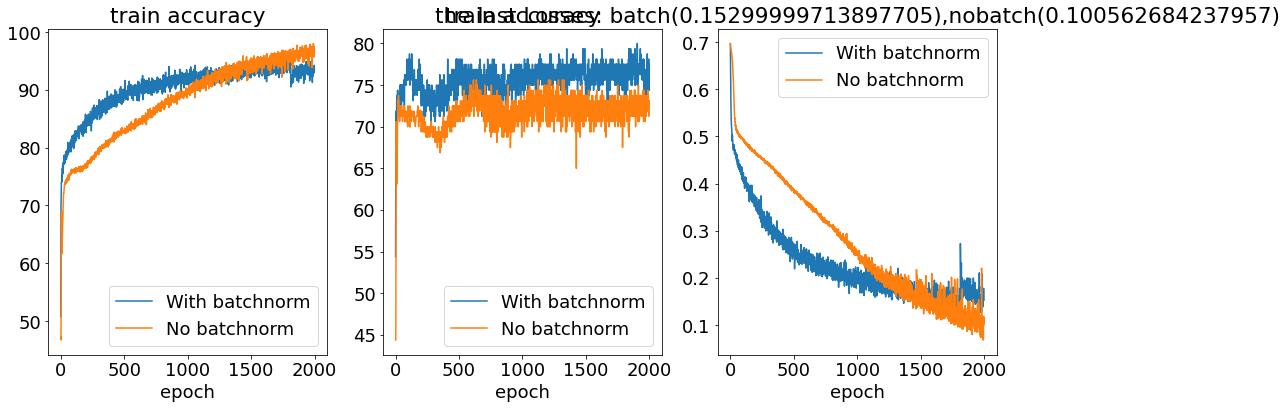

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(17,6))
axs[0].plot(trainAccWith_BN,label='With batchnorm')
axs[0].plot(trainAcc,label='No batchnorm')
axs[0].set_title('train accuracy')

axs[1].plot(testAccWith_BN,label='With batchnorm')
axs[1].plot(testAcc,label='No batchnorm')
axs[1].set_title('train accuracy')

axs[2].plot(lossesWith_BN,label='With batchnorm')
axs[2].plot(losses,label='No batchnorm')
axs[2].set_title(f'the last Losses: batch({(np.around(lossesWith_BN[-1],3))}),nobatch({losses[-1]})')

for i in range(3):axs[i].set_xlabel('epoch'),axs[i].legend()

